In [1]:
import importlib
import utils
importlib.reload(utils)
import utils.data
importlib.reload(utils.data)
import utils.snf
importlib.reload(utils.snf)
import dataset
importlib.reload(dataset)
import networks
importlib.reload(networks)
import utils.train_val_test
importlib.reload(utils.train_val_test)

print("libraries reloaded!")

from networks.encoders_decoders import H_Low_VAE, FcVaeA
from utils.train_val_test import train_loop, val_loop, SEED, plot_latent_space
from dataset import Omics_Dataset
from utils.data import read_MoGCN_data

import os
from torch.utils.data import DataLoader
from torch import optim, nn
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from functools import partial
import os
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.train import Checkpoint

libraries reloaded!


tensorboard --logdir /home/davide/Desktop/Projects/Multi-omics-data-integration-with-DL-approaches/prototype/results/tuning

### Load data

In [2]:
data_path = "data/train"
omics_file_names = ["fpkm_data.csv", "gistic_data.csv", "rppa_data.csv"]
gt_file_name = "sample_classes.csv"

omics_data, gt_data, samples_list, classes_list = read_MoGCN_data(
    omics_paths=[os.path.join(data_path, file) for file in omics_file_names],
    gt_data_path=os.path.join(data_path, gt_file_name),
)

In [30]:
for omics in omics_data:
    print(omics.shape[1])
    print(omics.head())

19581
    Sample     RAB4B     TIGAR     RNF44     DNAH3    RPL23A     ARL8B  \
0  A1-A0SF  2.067434  1.942403  3.560276  0.135735  7.743208  4.657533   
1  A1-A0SJ  1.957792  1.300873  3.570082  0.069682  7.233006  5.461097   
2  A1-A0SK  1.441807  3.745724  3.473475  0.109056  7.392388  4.063936   
3  A1-A0SO  1.581208  2.554524  2.639751  0.004098  7.022142  6.033742   
4  A2-A04P  2.825764  1.409889  3.044492  0.072995  6.786279  5.006774   

      CALB2     MFSD3      PIGV  ...   SLCO4C1  ARHGAP21     DDX47    POMZP3  \
0  1.223453  3.703006  2.805578  ...  0.073609  2.762001  0.418301  3.851872   
1  2.587125  3.860069  2.947874  ...  0.524515  3.036548  0.133315  1.618410   
2  1.485730  3.576430  1.763526  ...  2.022602  2.861571  0.961571  1.727583   
3  0.423807  2.604173  3.035735  ...  1.356618  4.038301  0.385972  2.270792   
4  5.161027  4.153998  2.112121  ...  0.119875  2.722981  0.403557  1.762943   

        SDS     TENM1    CYP4F2    PPP6R1     BATF3  OR8D4  
0  0.42

In [67]:
x_train , x_val, y_train, y_val = train_test_split(omics_data[1], gt_data, test_size=0.2, stratify=classes_list)

x_train.reset_index(inplace=True, drop=True)
x_val.reset_index(inplace=True, drop=True)

MoGCN_train = Omics_Dataset(x_train, y_train)
MoGCN_val = Omics_Dataset(x_val, y_val)

In [68]:
def hyper_loop(config):
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

    trainloader = DataLoader(
        MoGCN_train, batch_size=int(config["batch_size"]), shuffle=True
    )

    valloader = DataLoader(
        MoGCN_train, batch_size=int(config["batch_size"]), shuffle=True
    )
    net = H_Low_VAE(MoGCN_train.input_dims, "H_Low_VAE_omics_2", hidden_dim=config["hidden_dim"], latent_dim=config["latent_dim"])
    net.to(device)

    optimizer = optim.Adam(net.parameters(), lr=config["lr"])

    # To restore a checkpoint, use `train.get_checkpoint()`.
    # loaded_checkpoint = train.get_checkpoint()
    # if loaded_checkpoint:
    #     with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
    #         model_state, optimizer_state = torch.load(
    #             os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
    #         )
    #     net.load_state_dict(model_state)
    #     optimizer.load_state_dict(optimizer_state)


    for epoch in range(50):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, (inputs, _) in enumerate(trainloader):
            # forward + backward + optimize
            outputs, loss = net.forward_pass(inputs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        for i, (inputs, _) in enumerate(valloader):
            with torch.no_grad():
                outputs, loss = net.forward_pass(inputs)
                val_loss += loss.cpu().numpy()

        # Here we save a checkpoint. It is automatically registered with
        # Ray Tune and can be accessed through `train.get_checkpoint()`
        # API in future iterations.

        # output_dir = f"{net.name}_checkpoints"
        # os.makedirs(output_dir, exist_ok=True)
        # torch.save(
        #     (net.state_dict(), optimizer.state_dict()), f"{output_dir}/checkpoint.pt"
        # )
        # checkpoint = Checkpoint.from_directory(output_dir)
        # train.report({"loss": (val_loss / len(valloader))}, checkpoint=checkpoint)
        train.report({"loss": (val_loss / len(valloader))})

    print("Finished Training")

In [69]:
from ray.tune.search.optuna import OptunaSearch

config = {
    "hidden_dim": tune.choice([2**i for i in range(1, 8)]),
    "latent_dim": tune.choice([2**i for i in range(1, 8)]),
    "lr": tune.loguniform(1e-3, 1e-1, 5e-4),
    "batch_size": tune.choice([32, 64, 128]),
}
search_alg = OptunaSearch(
    metric="loss",
    mode="min",
)

scheduler = ASHAScheduler(
    time_attr="training_iteration",
    metric="loss",
    mode="min",
    max_t=100,
    grace_period=10,
    reduction_factor=3,
    brackets=1,
)

result = tune.run(
    hyper_loop,
    config=config,
    resources_per_trial={"cpu":6, "gpu": 1},
    scheduler=scheduler,
    search_alg=search_alg,
    num_samples=80,
    local_dir=(
        "/home/davide/Desktop/Projects/Multi-omics-data-integration-with-DL-approaches/prototype/results/tuning"
    ),
)

best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")

search_alg.save("./checkpoints/tuning/search_alg_omics_2.pkl")

2023-10-27 15:38:50,465	INFO tune.py:645 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
[I 2023-10-27 15:38:50,615] A new study created in memory with name: optuna


2023-10-27 15:38:50,927	WARNING worker.py:2058 -- Warning: The actor ImplicitFunc is very large (25 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Trial name,loss
hyper_loop_006d1244,0.0771516
hyper_loop_057349d6,0.086008
hyper_loop_05f165d7,0.0645956
hyper_loop_09336c72,0.0632774
hyper_loop_0a9274cf,0.0871226
hyper_loop_0dbe017a,0.0826416
hyper_loop_0e0f5a24,0.0643725
hyper_loop_1ae72991,0.132468
hyper_loop_1cddee82,0.066074
hyper_loop_1f2d8c5e,0.107841


(hyper_loop pid=13339) Finished Training
(hyper_loop pid=13639) Finished Training
(hyper_loop pid=13884) Finished Training
(hyper_loop pid=13933) Finished Training
(hyper_loop pid=14430) Finished Training
(hyper_loop pid=14480) Finished Training
(hyper_loop pid=14531) Finished Training
(hyper_loop pid=14684) Finished Training
(hyper_loop pid=14735) Finished Training
(hyper_loop pid=14951) Finished Training
(hyper_loop pid=15128) Finished Training
(hyper_loop pid=15173) Finished Training
(hyper_loop pid=15218) Finished Training
(hyper_loop pid=15394) Finished Training
(hyper_loop pid=15439) Finished Training
(hyper_loop pid=15483) Finished Training
(hyper_loop pid=15571) Finished Training
(hyper_loop pid=15661) Finished Training
(hyper_loop pid=15838) Finished Training
(hyper_loop pid=15883) Finished Training
(hyper_loop pid=16240) Finished Training
(hyper_loop pid=16284) Finished Training
(hyper_loop pid=16333) Finished Training
(hyper_loop pid=16377) Finished Training
(hyper_loop pid=

2023-10-27 15:53:01,777	INFO tune.py:1143 -- Total run time: 851.31 seconds (851.14 seconds for the tuning loop).


(hyper_loop pid=17047) Finished Training
Best trial config: {'hidden_dim': 128, 'latent_dim': 32, 'lr': 0.08709556577601364, 'batch_size': 32}
Best trial final validation loss: 0.0632774369283156


In [14]:
best_trial = result.get_best_trial("loss", "min")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")

search_alg.save("./checkpoints/tuning/search_alg_new.pkl")

Best trial config: {'hidden_dim': 256, 'latent_dim': 32, 'lr': 0.09851099274584903, 'batch_size': 32}
Best trial final validation loss: 4.281306006691673


## Training

In [111]:
omics_normalised = []
for omics in omics_data:
    df = omics.copy()
    values_cols = df.columns.difference(["Sample"])
    df[values_cols] = (df[values_cols] - df[values_cols].min(axis=0)) / (df[values_cols].max(axis=0)-df[values_cols].min(axis=0))
    omics_normalised.append(df)
    print(len(omics_normalised))

1
2
3


In [117]:
omics_normalised[0].shape

(434, 19581)

In [118]:
omics_normalised[0] = omics_normalised[0].dropna(axis=1, how='all')

In [91]:
df = omics_data[1].copy()
values_cols = df.columns.difference(["Sample"])
df[values_cols] = (df[values_cols] - df[values_cols].min(axis=0)) / (df[values_cols].max(axis=0)-df[values_cols].min(axis=0))
df

,Sample,CDK11A,NADK,PRKCZ,GNB1,SDF4,DVL1,MORN1,INTS11,ACAP3,...,CTAG1A,H2AB1,F8A2,F8A3,F8A1,H2AB3,H2AB2,VAMP7,IL9R,SPRY3
0,A1-A0SF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,A1-A0SJ,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,A1-A0SK,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,A1-A0SO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,A2-A04P,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,GM-A2DM,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
430,GM-A2DN,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
431,GM-A2DO,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
432,GM-A3NY,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [3]:
# Hyper
lr = 0.1
batch_size = 32

MoGCN_train = Omics_Dataset(omics_data[0], gt_data)
train_loader = DataLoader(MoGCN_train, batch_size=batch_size, shuffle=True)

# Model Initialisation
model = FcVaeA(
    [MoGCN_train.input_dims],
)

optimizer = optim.Adam(model.parameters(), lr=lr)
model.to(model.device)

loss_ls, best_model = train_loop(
    model,
    optimizer,
    train_loader,
    output_path="./checkpoints",
    num_epochs=100,
    val_data=None,
    early_stopping_mode="train_loss",
)

# latent_space = model.get_latent_space(MoGCN_train.omics_data)
# plot_latent_space(latent_space, MoGCN_train.gt_labels)

# sns.lineplot(data=pd.DataFrame(loss_ls))
# plt.show()

ValueError: expected 2D or 3D input (got 1D input)

epoch: 1 | train loss: 0.1120   
epoch: 5 | train loss: 0.1033   
epoch: 10 | train loss: 0.1000   
epoch: 15 | train loss: 0.0956   
epoch: 20 | train loss: 0.0948   
epoch: 25 | train loss: 0.0941   
epoch: 30 | train loss: 0.0911   

Best epoch: 30 | train_loss 0.0911
T-SNE KL Divergence:  1.4646605253219604


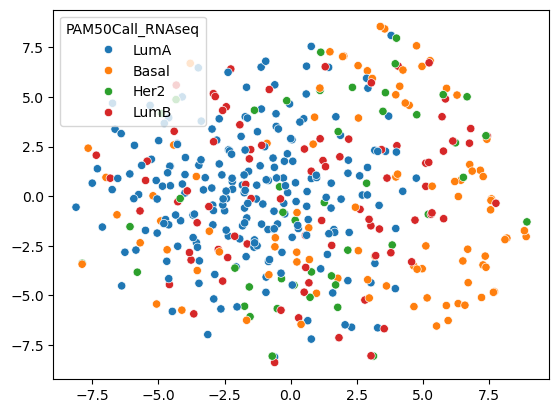

1.4646605253219604

In [6]:
# Hyper
lr = 0.001
batch_size = 32

MoGCN_train = Omics_Dataset(omics_data[1], gt_data)
train_loader = DataLoader(MoGCN_train, batch_size=batch_size, shuffle=True)

# Model Initialisation
model = H_Low_VAE(
    MoGCN_train.input_dims,
    f"H_Low_VAE_omics_B",
    hidden_dim=256,
    latent_dim=32,
    beta=0.01,
    dropout_p=0.2,
    activation_fn=nn.ELU(),
)

optimizer = optim.Adam(model.parameters(), lr=lr)
model.to(model.device)

loss_ls, best_model = train_loop(
    model,
    optimizer,
    train_loader,
    output_path="./checkpoints",
    num_epochs=30,
    val_data=None,
    early_stopping_mode="train_loss",
)

latent_space = model.get_latent_space(MoGCN_train.omics_data)
plot_latent_space(latent_space, MoGCN_train.gt_labels)

epoch: 1 | train loss: 0.2266   
epoch: 5 | train loss: 0.1763   
epoch: 10 | train loss: 0.1327   
epoch: 15 | train loss: 0.1035   
epoch: 20 | train loss: 0.0848   
epoch: 25 | train loss: 0.0722   
epoch: 30 | train loss: 0.0645   

Best epoch: 30 | train_loss 0.0645
T-SNE KL Divergence:  1.0283483266830444


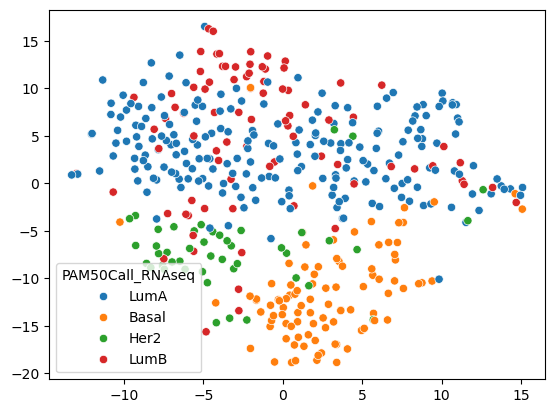

1.0283483266830444

In [138]:
# Hyper
lr = 0.001
batch_size = 32

MoGCN_train = Omics_Dataset(omics_normalised[2], gt_data)
train_loader = DataLoader(MoGCN_train, batch_size=batch_size, shuffle=True)

# Model Initialisation
model = H_Low_VAE(
    MoGCN_train.input_dims,
    f"H_Low_VAE_omics_C",
    hidden_dim=256,
    latent_dim=32,
    beta=0.001,
    dropout_p=0.2,
    activation_fn=nn.ELU(),
)

optimizer = optim.Adam(model.parameters(), lr=lr)
model.to(model.device)

loss_ls, best_model = train_loop(
    model,
    optimizer,
    train_loader,
    output_path="./checkpoints",
    num_epochs=30,
    val_data=None,
    early_stopping_mode="train_loss",
)

latent_space = model.get_latent_space(MoGCN_train.omics_data)
plot_latent_space(latent_space, MoGCN_train.gt_labels)